<a href="https://colab.research.google.com/drive/13Hg_JMz_3BTzRTpNwhHM5Pz68MN6yndY?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

## CAM 
**Class Activation Map (CAM)** visualization techniques produce heatmaps of 2D class activation over input images, showing how important each location is for  considered class considered. 

## Grad-CAM
In the paper [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), the visualization is conducted by taking the output feature map of a convolution layer (given an input image), and then weighing every channel (feature map) by the gradient of the output class wrt the feature map.

![Grad-Cam](https://www.mathworks.com/help/examples/nnet/win64/GradCAMRevealsTheWhyBehindDeepLearningDecisionsExample_02.png)

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [0]:
# load the model
model = VGG16(weights='imagenet')

In [73]:
# download an image
#!wget -nv https://i.pinimg.com/736x/18/86/a8/1886a88d9d7af5dafd5b8b175185dafd.jpg -O ex01.jpg
#!wget -nv https://proudfootcreams.files.wordpress.com/2013/05/img_8799.jpg -O ex01.jpg
!wget -nv https://image.freepik.com/free-photo/asian-man-with-dog-golden-retriever-park_1286-769.jpg -O ex01.jpg

2020-05-17 19:05:27 URL:https://image.freepik.com/free-photo/asian-man-with-dog-golden-retriever-park_1286-769.jpg [104767/104767] -> "ex01.jpg" [1]


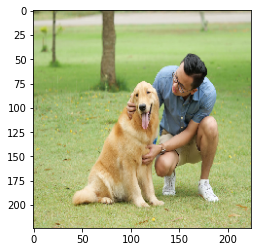

In [74]:
# image load and resize
img_path = 'ex01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [0]:
# image preprocess
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [76]:
# predict (just fo sainty)
preds = model.predict(x)
print(decode_predictions(preds, top=3)[0])
cls_id = np.argmax(preds[0])
print(cls_id) # the output index

[('n02099601', 'golden_retriever', 0.5953543), ('n02091831', 'Saluki', 0.14588782), ('n02088094', 'Afghan_hound', 0.046825964)]
207


In [0]:
output_point = model.output[:, cls_id]

# Select the last conv layer
feature_maps = model.get_layer('block5_conv3')

# grads of the output wrt the conv layer
grads = K.gradients(output_point, feature_maps.output)[0]

# grads has the same shape as the selected conv layer
# the weight of each feature map is simple the mean of the grads
mean_grads = K.mean(grads, axis=(0, 1, 2))

# the function
iterate = K.function([model.input], [mean_grads, feature_maps.output[0]])

mean_grads_value, feature_maps_value = iterate([x])

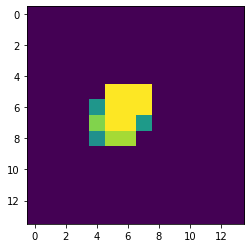

In [78]:
# sample feature mapnumber 200 
feature_map = feature_maps_value[:, :, 200].copy()
feature_map -= feature_map.mean()
feature_map /= feature_map.std()
feature_map *= 64
feature_map += 128
feature_map = np.clip(feature_map, 0, 255).astype('uint8')
plt.imshow(feature_map)

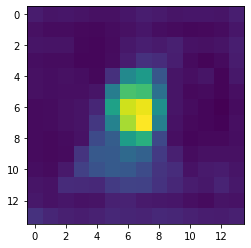

In [79]:
# mean of all feature maps (without weighting)
plt.imshow(np.mean(feature_maps_value, axis=-1))

In [0]:
# weight each feature map by its mean gradinet
for i in range(512):
    feature_maps_value[:, :, i] *= mean_grads_value[i]

# The heatmap the mean of all weighted maps
heatmap = np.mean(feature_maps_value, axis=-1)

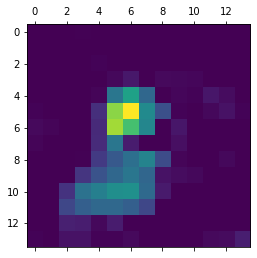

In [81]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [0]:
# overlay 
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

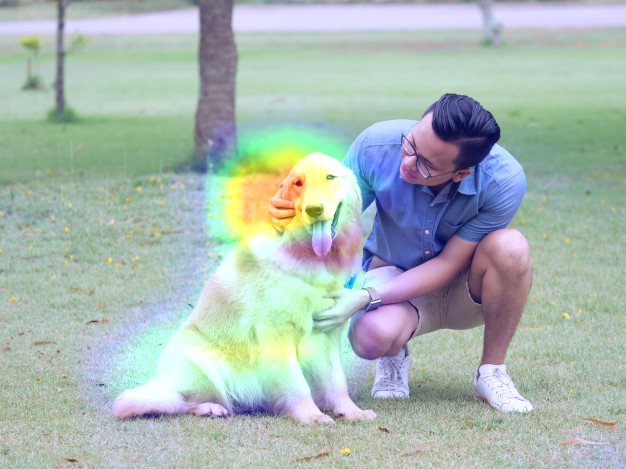

In [83]:
superimposed_img = heatmap * 0.4 + img
cv2_imshow(superimposed_img)